# CMPS 290C: Dimensionality Reduction Miniproject

Keller Jordan, Sanjay Krishna Gouda, Brett Gohre, Numra Bathool

We apply t-SNE, LargeVis, and TriMap to the [ISOLET dataset](https://archive.ics.uci.edu/ml/datasets/ISOLET) of spoken alphabet letters, and report various metrics of visualization quality. We also demonstrate an alternative way to copy and shift a dataset that is well-visualized by all three methods. Lastly, we animate the training of TriMap with five optimizers to gain intuition on both TriMap and the optimization techniques, contained separately in `/animations`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.decomposition import TruncatedSVD

# load ISOLET dataset
df1 = pd.read_csv('data/isolet1+2+3+4.data', header=None)
df2 = pd.read_csv('data/isolet5.data', header=None)
df = pd.concat([df1, df2], axis=0)
X = np.array(df.iloc[:, :-1])
labels = np.array(df.iloc[:, -1])

# min-max scale, zero-center, and reduce dataset to top 50 SVD components
X -= np.min(X)
X /= np.max(X)
X -= np.mean(X, axis=0)
X = TruncatedSVD(n_components=50, random_state=0).fit_transform(X)

In [3]:
from sklearn.manifold import TSNE
import trimap # PyTorch implementation of TriMap for fast GPU embedding

# embed into 2D space using t-SNE, LargeVis, and TriMap
Y_tsne = TSNE(n_components=2, perplexity=30.0, n_iter=2000).fit_transform(X)
Y_largevis = np.loadtxt('data/isolet_Y.txt')
Y_trimap = trimap.embed(X)

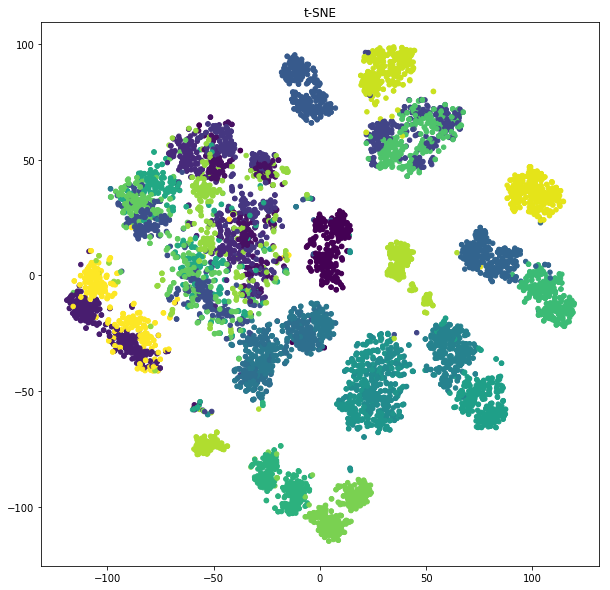

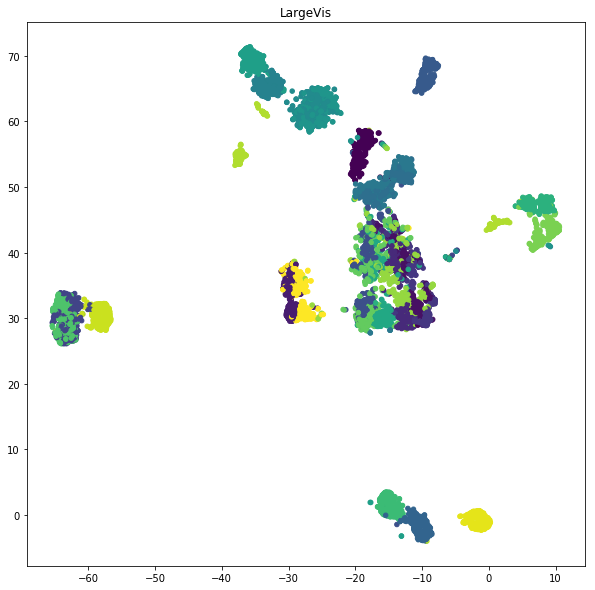

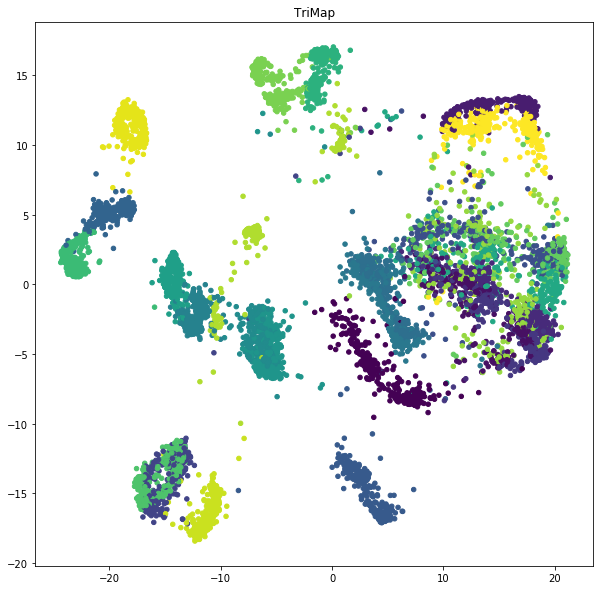

In [4]:
def plot_embedding(Y, labels, title):
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(Y[:, 0], Y[:, 1], 20, labels)
    plt.title(title)

plot_embedding(Y_tsne, labels, title='t-SNE')
plot_embedding(Y_largevis, labels, title='LargeVis') # TODO
plot_embedding(Y_trimap, labels, title='TriMap')
plt.show()

# Metric Evaluation

Evaluation metrics applied are ROC (true positive vs. false positive), precision-recall, and trustworthiness-continuity. All plots are created using output neighborhood sizes ranging from size 1 to 500. Over the first two metrics, TriMap performs the best with high values as it preserves global structure, while t-SNE performs best at small neighborhoods as it preserves a highly local probability distribution (gaussian in input space). LargeVis falls in between the two metrics.

The trustworthiness-continuity plot is difficult to interpret without labels for neighborhood sizes, but it appears that TriMap similarly performs best at high neighborhoods as the furthest point is closer to the optimal top-right corner. On the other hand, LargeVis and t-SNE perform similarly, with LargeVis being more truthworthy and t-SNE more continuous. Trustworthiness-continuity is implemented according to [5].

In [5]:
from importlib import reload
import metrics
reload(metrics)

from metrics import Metrics
from sklearn.neighbors import NearestNeighbors as knn

_, nbrs_input = knn(n_neighbors=X.shape[0]).fit(X).kneighbors(X)

metrics_tsne = Metrics(nbrs_input, Y_tsne)
metrics_largevis = Metrics(nbrs_input, Y_largevis)
metrics_trimap = Metrics(nbrs_input, Y_trimap)

In [6]:
tp_tsne, fp_tsne = metrics_tsne.roc_metrics()
precision_tsne, recall_tsne = metrics_tsne.mean_precision_recall()
trust_tsne, cont_tsne = metrics_tsne.trustworthiness_continuity()
tp_largevis, fp_largevis = metrics_largevis.roc_metrics()
precision_largevis, recall_largevis = metrics_largevis.mean_precision_recall()
trust_largevis, cont_largevis = metrics_largevis.trustworthiness_continuity()
tp_trimap, fp_trimap = metrics_trimap.roc_metrics()
precision_trimap, recall_trimap = metrics_trimap.mean_precision_recall()
trust_trimap, cont_trimap = metrics_trimap.trustworthiness_continuity()

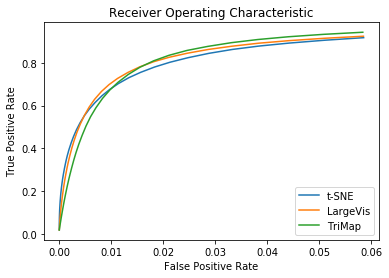

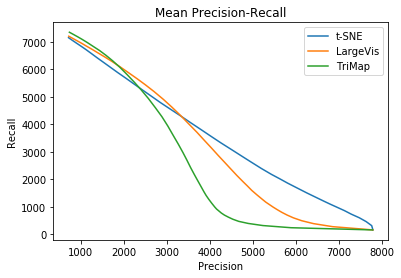

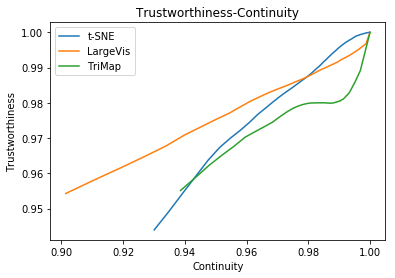

In [7]:
plt.figure()
plt.plot(fp_tsne, tp_tsne, label='t-SNE')
plt.plot(fp_largevis, tp_largevis, label='LargeVis')
plt.plot(fp_trimap, tp_trimap, label='TriMap')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()

plt.figure()
plt.plot(precision_tsne, recall_tsne, label='t-SNE')
plt.plot(precision_largevis, recall_largevis, label='LargeVis')
plt.plot(precision_trimap, recall_trimap, label='TriMap')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Mean Precision-Recall')
plt.legend()

plt.figure()
plt.plot(cont_tsne, trust_tsne, label='t-SNE')
plt.plot(cont_largevis, trust_largevis, label='LargeVis')
plt.plot(cont_trimap, trust_trimap, label='TriMap')
plt.xlabel('Continuity')
plt.ylabel('Trustworthiness')
plt.title('Trustworthiness-Continuity')
plt.legend()

plt.show()

# Shifting copied data "across" dimensions

We have seen in [1] that when copying a dataset, shifting each point by some fixed value, and concatenating with the original, t-SNE and LargeVis fail to display this structure while TriMap succeeds. Another way to copy and "shift" the dataset is to move "across" dimensions by shifting all pixels of each image in a direction. In the following cells, we create two copies of a subset of binary-valued MNIST, add 10 pixels of width either to the right or left-hand side, and then concatenate to create a single dataset.

In the old method of shifting, clusters in one copy may be shifted in such a way that they end up close to clusters in another copy. In this method, because of the centering of each digit in MNIST, clusters in one copy are only spatially close to other clusters in their same copy. We therefore expect all three DR techniques to be able to preserve this structure, and this is exactly what we observe.

In [8]:
X = np.loadtxt('data/mnist2500_X.txt')
labels = np.loadtxt('data/mnist2500_labels.txt')

n, dim = X.shape
side = int(dim**.5)
X = X.reshape(n, side, side)

# X1: shifted 10 pixels to the left
X1 = np.ones((n, 38, 28))
# X2: shifted 10 pixels to the right
X2 = np.ones((n, 38, 28))

X1[:, :-10, :] = X
X2[:, 10:, :] = X

X1 = X1.reshape(n, 38*28)
X2 = X2.reshape(n, 38*28)

X = np.concatenate((X1, X2), 0)
labels = np.concatenate((labels.copy(), labels.copy()), 0)

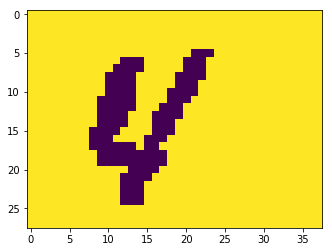

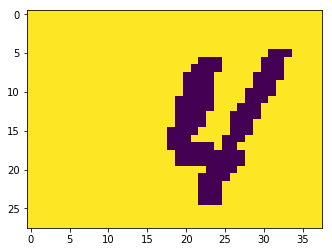

In [9]:
plt.figure()
plt.imshow(X[700].reshape(38, 28).T)
plt.figure()
plt.imshow(X[700+2500].reshape(38, 28).T)
plt.show()

In [10]:
Y_tsne = TSNE(n_components=2, perplexity=30.0, n_iter=2000, verbose=False).fit_transform(X)
Y_largevis = np.loadtxt('data/mnist2500_shift_Y.txt')
Y_trimap = trimap.embed(X)

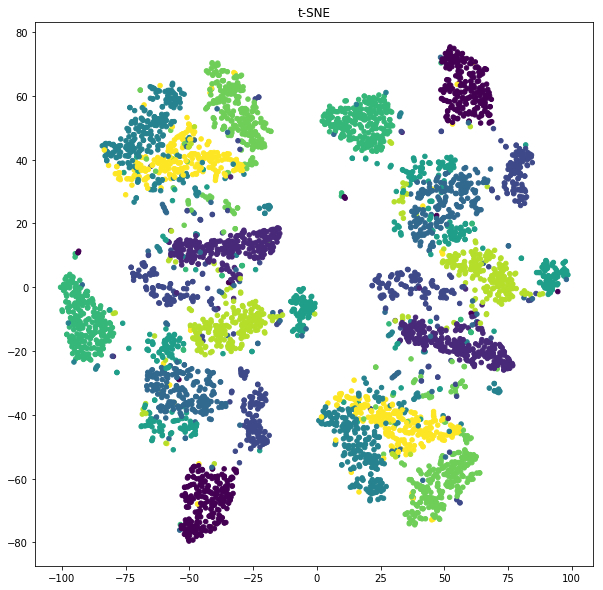

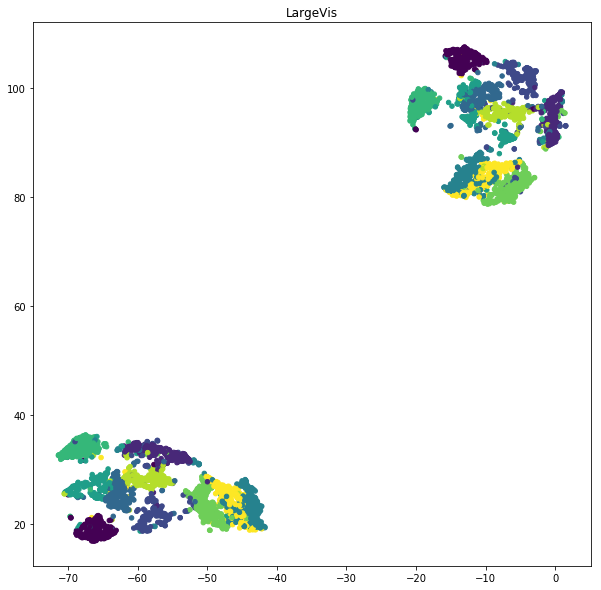

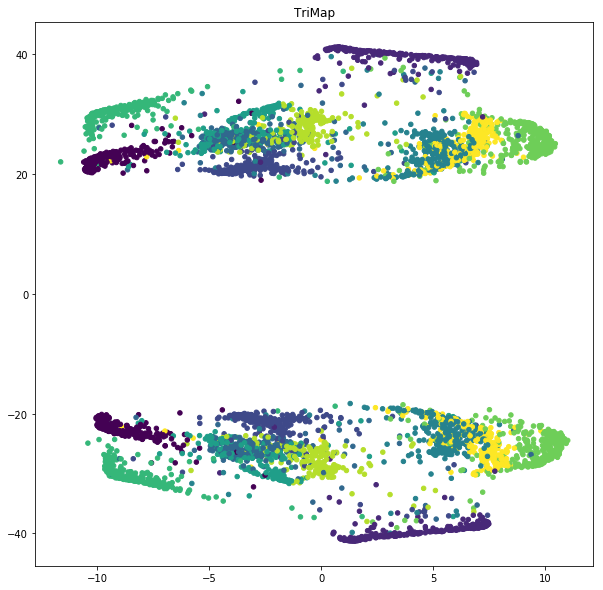

In [11]:
plot_embedding(Y_tsne, labels, title='t-SNE')
plot_embedding(Y_largevis, labels, title='LargeVis')
plot_embedding(Y_trimap, labels, title='TriMap')
plt.show()

### References

1. Ehsan Amid and Manfred K. Warmuth. 2018. Transformation invariant and outlier revealing dimensionality reduction using triplet embedding. In Proceedings of The Web Conference (Web’18). ACM, New York, NY, USA, 10 pages. https://doi.org/10.475/123_4
2. Jian Tang, Jingzhou Liu, Ming Zhang, and Qiaozhu Mei. 2016. Visualizing largescale and high-dimensional data. In Proceedings of the 25th International Conference on World Wide Web. International World Wide Web Conferences Steering Committee, 287–297.
3. Laurens van der Maaten and Geoffrey Hinton. 2008. Visualizing data using t-SNE. Journal of Machine Learning Research 9, Nov (2008), 2579–2605.
4. Jarkko Venna, Jaakko Peltonen, Kristian Nybo, Helena Aidos, and Samuel Kaski. 2010. Information retrieval perspective to nonlinear dimensionality reduction for data visualization. Journal of Machine Learning Research 11, Feb (2010), 451–490.
5. Venna, J., & Kaski, S. (2005). Local multidimensional scaling with controlled tradeoff between trustworthiness and continuity. In Proceedings of the workshop on self-organizing maps (pp. 695–702).